# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.,2.], cov=[[1., 0.5],[0.5, 1.]])
mv2 = multivariate_normal(mean=[-3.,-3.], cov=[[1., 0.],[0., 1.]])

def prob(x):
  return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
  p_x = []
  for i in range(len(x1)):
    for j in range(len(x2)):
      p_x.append(prob(np.asarray([[x1[i], x2[j]]])))
    
  return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10., 10., 400)
x2 = np.linspace(-10., 10., 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

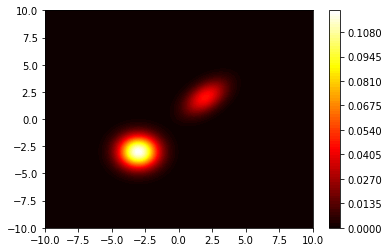

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap='hot')
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
A mode is the most probable value in a set of data values, in this case we have two modes. One is contained in the subspace [0.0,-5.0]^2 and a lower one at [5.0,0.0]^2. The most probable point is in the middle of the left mode which means somewhere around -2.5,2.5

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:** $q(\mathbf{x}_{new} | \mathbf{x}_{old}) = N(\mathbf{x}_{old} |  \sigma^{2} )$


**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
Yes, it is a proper proposal dristribution since it fulfill irreducibility and aperiodicity. Indeed, it is possible to reach any other state from the current state (irreducibility) and there is a self-transition and it cannot get stuck in a cycle so it also fulffil aperiodicity. 

In [6]:
from numpy import random

In [41]:
#=========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
#=========
# Implement the Metropolis Hasting (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then. 
class MetropolisHastings(object):
  def __init__(self, x, prob, std=0.1):
    self.prob = prob
    self.std = std
    self.x_old = x

  def proposal(self, x):
    # PLEASE FILL IN
    # sample x' ~ q(x|x')
    x_new = np.random.normal(x,self.std,size=[1,2]) 
    return x_new

  def evaluate(self, x_new, x_old):
    #evaluate the x value through the acceptance probability
    A = self.prob(x_new)/self.prob(x_old)
    return np.minimum(1., A)
  
  def select(self, x_new, A):
#   u~ Unif[0,1]
    u = np.random.uniform(0.,1.)  

    #  check if acceptance probability is larger than u 
    if A > u:
        self.x_old = x_new # we accept the new point
        return x_new
    else:
        return self.x_old # otherwise we keep the old point
        
  def step(self):
    # 1. Proposal
    x_prop = self.proposal(self.x_old)
    # 2. Evaluate
    A = self.evaluate(x_prop, self.x_old)
    # 3. Select
    x_new = self.select(x_prop, A)
    return x_new

In [42]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
  # Plot the objective function
  ax.contourf(x1, x2, p_x/p_x.sum(), 100, cmap='hot')

  # Init the solution
  x_samp = sampler.x_old
  # Run the optimization algorithm
  count = 0 # we calculate how many of new candidates were accepted
  for i in range(num_epochs):
    x = sampler.step()

    if (x == x_samp[-1]).all():
      pass
    else:
      count = count + 1
      x_samp = np.concatenate((x_samp, x),0)

  ax.scatter(x_samp[:,0], x_samp[:,1], marker='+')
  # We add AR (Acceptance Rate) to the title.
  ax.set_title(title + ' AR={:.2f}'.format(count/num_epochs))

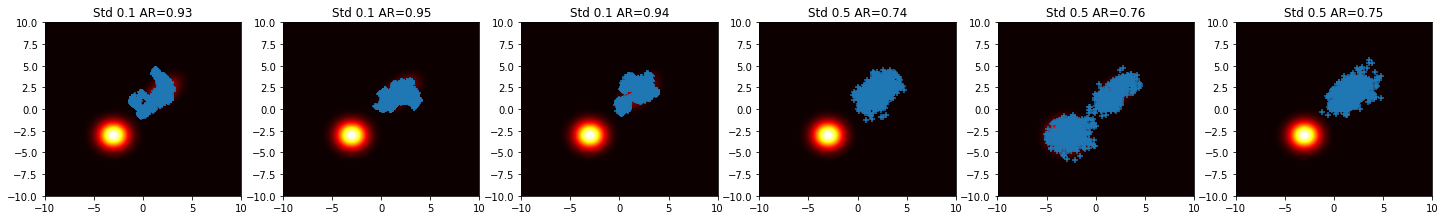

In [46]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1,len(stds),figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0., 0.]])

for i in range(len(stds)):
  # take the std
  std = stds[i]
  # init the MH
  mh = MetropolisHastings(x=x_init, prob=prob, std=std)
  # plot the convergence
  plot_sampling_process(axs[i], sampler=mh, title='Std ' + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes?

**Answer**:The higher value of standard deviation increases the probability of sampling from both modes, this is because it determines how far the new candidate can move from the old candidate. This leads to less spread and more condensated results for a lower standard deviation.
And no, is not always possible to sample from both modes, as we can see in the above results just one of the st=0.5 experiment sample from both modes. 

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: The acceptance ratio is higher with the standard deviation of 0.1, with values around 0.95 for all the three experiment. The acceptance ratio with the higher standard deviation of 0.5 is lower, with an average of 0.75 for the three different experiments. The acceptance ratio is given by the ratio between the number of new candidates that were accepted and the number of epochs, therefore an higher standard deviation would lead to more candidates being discarded since the average amount of variability between the points will be higher.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: MH and SA are really similar apart from the addition of a variable in SA. In SA we introduce another quantity called temperature. There is indeed an extra step that iterative minimize the cooling schedule. 
By flattening the mixture of the gaussians then the probability of jumbing between two modes is higher. 

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: The use of SA offers an higher probability of jumping between different modes. SA is more optimal for optimization thanks to the Temperature variable, which according to its value would give us information about the distribution: high temperature -> uniform distribution, low temperature -> peaky distribution


In [10]:
from math import exp

In [66]:
#=========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
#=========
# Implement the Simulated Annealing (SA) algorithm. 
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
  def __init__(self, x, prob, std=0.1, T0=1., C=1.):
    self.prob = prob
    self.std = std
    self.x_old = x
    self.T0 = T0
    self.C = C
    self.t = 0 # we init the step number to 0; we need it for cooling scheme

  def proposal(self, x):
    # PLEASE FILL IN #same as before
    # sample x' ~ q(x|x')
    x_new = np.random.normal(x,self.std,size=[1,2])
    return x_new

  def evaluate(self, x_new, x_old, T):
    # PLEASE FILL IN 
    A = (self.prob(x_new)**(1/T))/(self.prob(x_old)**(1/T))
    return np.minimum(1., A)
  
  def select(self, x_new, A):
#   u~ Unif[0,1]
    u = np.random.uniform(0.,1.)  
    #  check if acceptance probability is larger than u 
    if A > u:
        self.x_old = x_new # we accept the new point
        return x_new
    else:
        return self.x_old # otherwise we keep the old point
        

  def step(self):
    # The temperature scheme (the cooling scheme)
    T = (self.C*(np.log(self.t+self.T0)+EPS))**(-1) #EPS added to avoid RuntimeWarning error 
    self.t = self.t + 1
    # 1. Proposal
    x_prop = self.proposal(self.x_old)
    # 2. Evaluate
    A = self.evaluate(x_prop, self.x_old, T)
    # 3. Select
    x_new = self.select(x_prop, A)
    return x_new

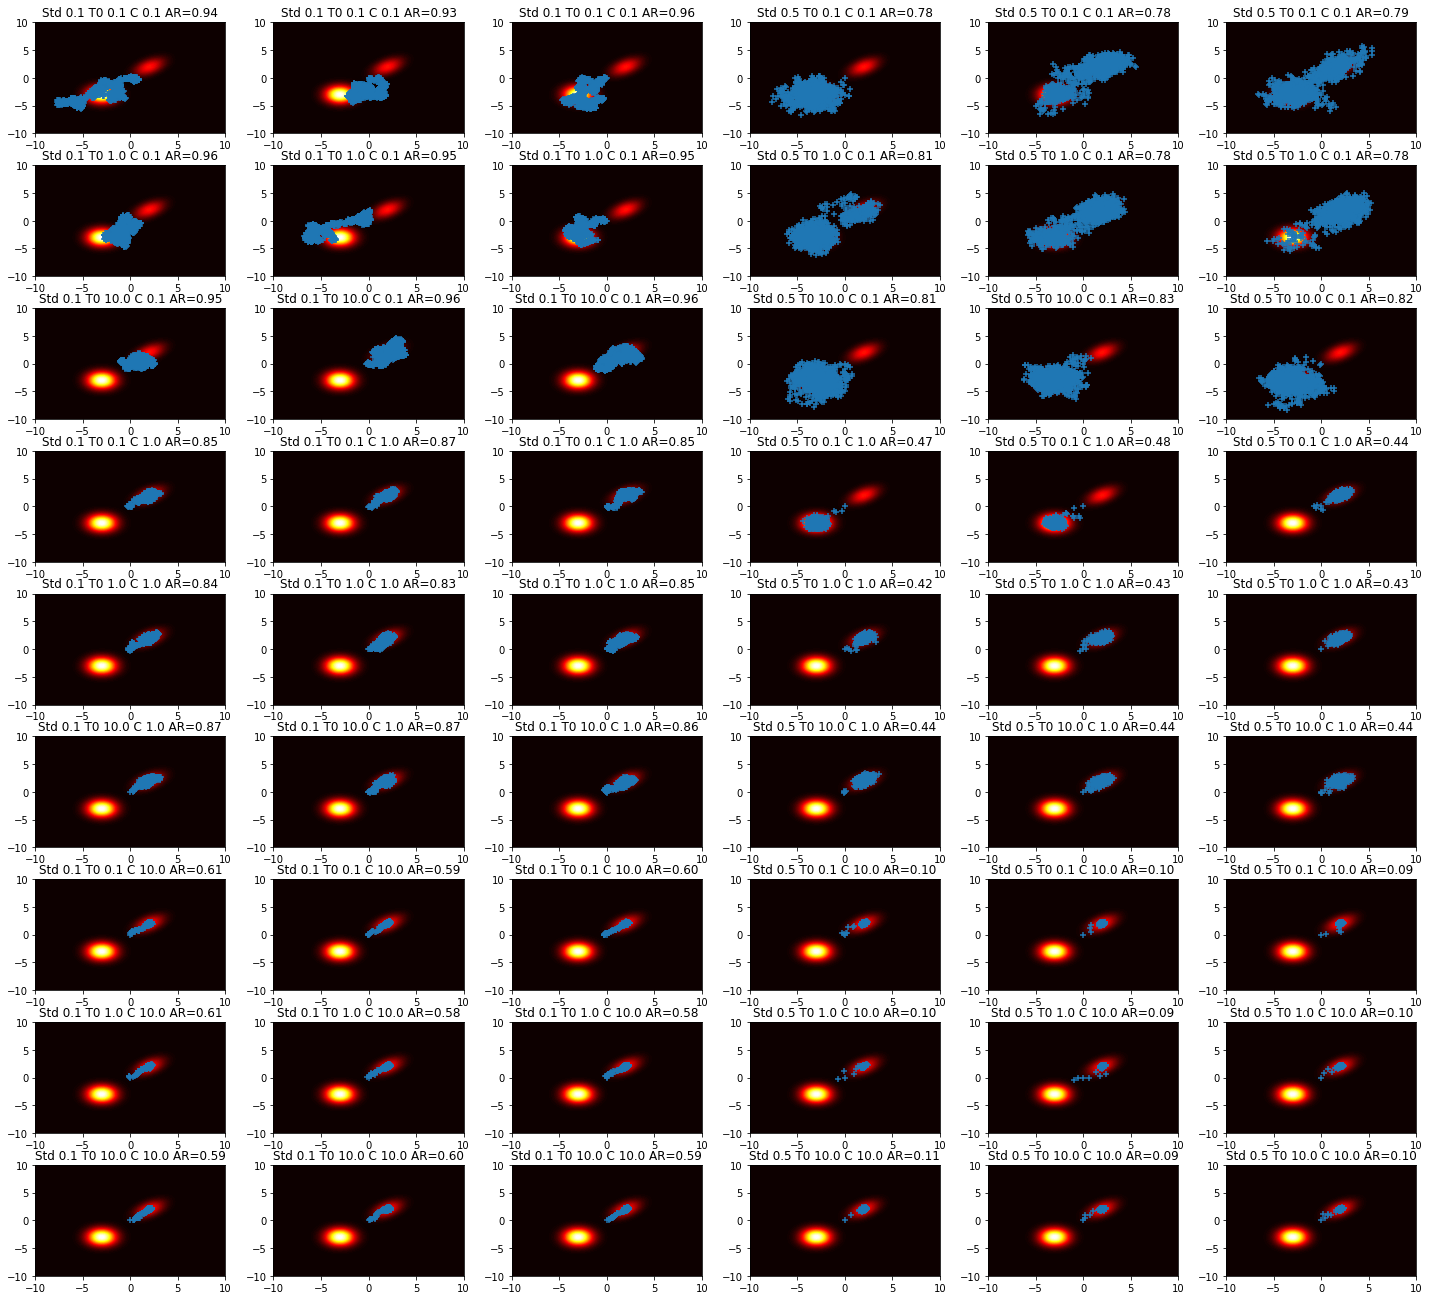

In [67]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds_sa = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # values of std; notice we repeat them due to randomness
T0s = [0.1, 1., 10.] # values of T0
Cs = [.1, 1., 10.] # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s),len(stds_sa),figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0., 0.]])

# START SA
for i in range(len(Cs)):
  # Take a value for C
  C = Cs[i]
  for k in range(len(T0s)):
    # Take a value for the init temperature T0
    T0 = T0s[k]
    for j in range(len(stds_sa)):
      # take the std
      std = stds_sa[j]
      # init the SA
      sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
      # plot the sampling process
      plot_sampling_process(axs[len(T0s)*i+k,j], sampler=sa, title='Std ' + str(sa.std) + ' T0 ' + str(T0) + ' C ' + str(C))

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** A lower standard deviation makes the results more uniform and less spread. We can notice that the first three columns show less outliers in confront to the las three columns of standard deviation 0.5. An higer standard deviation makes the new candidate move further from the current candidate. 
Moreover, the AR value is higher with a standard deviation of 0.1

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** The initial temperture  $T_0$ effects the cooling scheme of SA, since T is given by $(C*log(t+T0))^{-1}$. It influes the perturbation ratio of the simulated annealing algorithm.

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** With an higher constant C we can notice that the samples covers a smaller area. An higher C makes the 'explored' space smaller, we can see how the first three rows samples are way more spread in the search space compared to the last three rows.  

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** The best performing sample seems to be the one with std=0.5, T0 = 1.0 and C = 0.1. This is the only combination that covers both of the modes.

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** The initial temperature and the standard deviation are the values that influence the most the acceptance ratio. As explained earlier an higher standard deviation leads to a bigger distance from the old candidate and the new candidate, therefore the risk of the new candidate being declined is higher with an higher standard deviation making the acceptance ratio lower. A lower constant C also lead to higher acceptance ratio, this is probablu due the fact that since a bigger area of the space is covered with a lover constant C, the chance of a point being better or different than the previous one increases. 

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: I would say that MH performed better since 1/6 samples perfectly represent the gaussian distribution while almost none of the 54 experiemnt with SA correctly represent the given probability distribution. 

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: MH is definetely easier to use since it does not have the additional step of using a cooling scheme. In MH just the parameter of standard deviation has to be set and tested while with simulated annealing we have to set the standard deviation, the C constant and the initial temperture as well as choosing which cooling scheme to use. 